In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os
from huggingface_hub import login
from google.colab import userdata

# Accessing the secret key from Colab secrets
hf_token = userdata.get("HF_API_KEY")

if hf_token:
    login(token=hf_token)
else:
    raise ValueError("Hugging Face token not found in Colab secrets 'Colab_HF_token'")

In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [35]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test (6).csv')
test_df.head()

,unique_id,time,x,y,red,nir,swir16,swir22,blue,green,rededge1,rededge2,rededge3,nir08
0,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
1,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
2,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
3,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
4,ID_01FHV4,2018-03-14 10:59:24.436,-296455.0,846395.0,0.5312,0.6296,0.6643,0.5882,0.5244,0.5308,0.6016,0.6217,0.6401,0.6404


In [36]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentinel2_CropSamples_Reorganized (1).csv')
train_df.head()

,blue,crop_type,green,nir,nir08,red,rededge1,rededge2,rededge3,swir16,swir22,time,unique_id,x,y
0,559,cocoa,771,2404,2585,846,1240,2006,2326,2630,1684,2022-01-03,PIXEL_0001,0.957526,6.899852
1,537,cocoa,916,2448,2750,1096,1464,2124,2390,2851,1823,2022-01-08,PIXEL_0001,0.957526,6.899852
2,540,cocoa,877,2402,2498,1084,1415,1943,2184,3069,2100,2022-01-23,PIXEL_0001,0.957526,6.899852
3,1944,cocoa,2094,3076,3307,2260,2537,2809,3043,3887,2979,2022-01-28,PIXEL_0001,0.957526,6.899852
4,2062,cocoa,2092,2484,2599,2210,2293,2371,2529,2837,2275,2022-02-12,PIXEL_0001,0.957526,6.899852


In [37]:
train_df['crop_type'].value_counts()

,count
crop_type,
cocoa,6359
rubber,6283
oil,5800


In [38]:
from transformers import AutoModel
model_name = "AminiTech/amini-28M-v1"
model = AutoModel.from_pretrained(model_name)
import torch

# Ensure that the model and inputs are on the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

PatchTSTModel(
  (scaler): PatchTSTScaler(
    (scaler): PatchTSTMeanScaler()
  )
  (patchifier): PatchTSTPatchify()
  (masking): PatchTSTMasking()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=512, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-5): 6 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_path2): Identity()
        (norm_sublayer2): LayerNorm((512,), 

In [39]:
band_columns = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3',
                'nir', 'nir08', 'swir16', 'swir22']

train_df['time'] = pd.to_datetime(train_df['time'])
df_sorted = train_df.sort_values(['unique_id', 'time'])

grouped = df_sorted.groupby('unique_id')
tensor_list, ids, labels = [], [], []

for uid, group in grouped:
    arr = group[band_columns].values
    if arr.shape[0] >= 48:
        arr = arr[:48]
        arr = (arr - arr.mean(0)) / (arr.std(0) + 1e-6)
        tensor_list.append(torch.tensor(arr, dtype=torch.float32))
        ids.append(uid)
        labels.append(group['crop_type'].iloc[0])

X = torch.stack(tensor_list).to(device)  # (N, 48, 10)

In [40]:
# Get embeddings
with torch.no_grad():
    out = model(past_values=X)
embeddings = out.last_hidden_state[:, 0, :]  # CLS token → (N, 512)

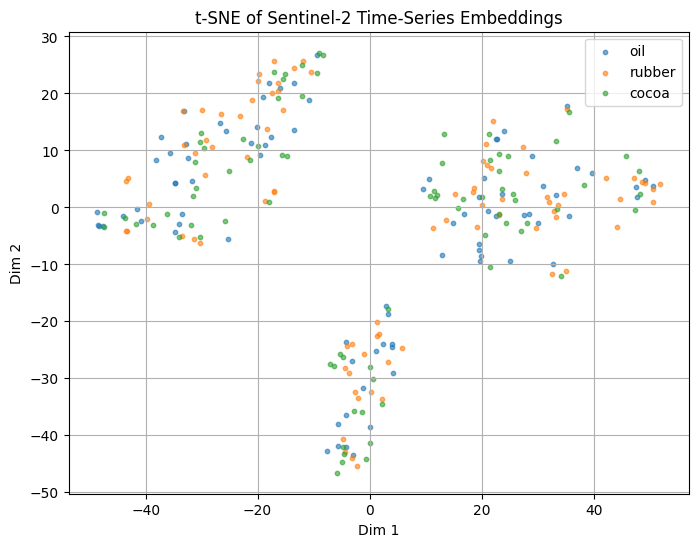

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ----- flatten safely -----
if embeddings.ndim > 2:
    emb_np = embeddings.reshape(-1, embeddings.shape[-1]).cpu().numpy()
else:
    emb_np = embeddings.cpu().numpy()

# ----- t‑SNE -----
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# ----- plot -----
plt.figure(figsize=(8, 6))
for crop in set(labels):
    idx = [i for i, l in enumerate(labels) if l == crop]
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=crop, s=10, alpha=0.6)

plt.legend()
plt.title("t‑SNE of Sentinel‑2 Time‑Series Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

In [43]:
# Step 1: Flatten embedding to 2D
emb_flat = embeddings[:, 0, :]  # or embeddings.mean(dim=1)

# Step 2: Convert to DataFrame
df_train_embed = pd.DataFrame(emb_flat.cpu().numpy())

# Step 3: Add IDs and labels
df_train_embed.insert(0, 'unique_id', ids)
df_train_embed['crop_type'] = labels

# Step 4: Save
df_train_embed.to_csv("train_embeddings.csv", index=False)
print("✅ Saved train_embeddings.csv | Shape:", df_train_embed.shape)



✅ Saved train_embeddings.csv | Shape: (251, 514)


In [44]:
import torch

# Setup
band_columns = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3',
                'nir', 'nir08', 'swir16', 'swir22']
test_df['time'] = pd.to_datetime(test_df['time'])
df_test_sorted = test_df.sort_values(['unique_id', 'time'])
grouped_test = df_test_sorted.groupby('unique_id')

# Pre-extract pixel sequences (only valid ones with >= 48 time steps)
tensor_list_test, test_ids, test_labels = [], [], []
for uid, group in grouped_test:
    arr = group[band_columns].values
    if arr.shape[0] >= 48:
        arr = arr[:48]
        arr = (arr - arr.mean(0)) / (arr.std(0) + 1e-6)
        tensor_list_test.append(torch.tensor(arr, dtype=torch.float32))
        test_ids.append(uid)


# ---- Batched inference ----
batch_size = 500
embeddings_all = []

model.eval()
with torch.no_grad():
    for i in range(0, len(tensor_list_test), batch_size):
        batch = tensor_list_test[i:i+batch_size]
        X_batch = torch.stack(batch).to(device)  # (B, 48, 10)
        out = model(past_values=X_batch)
        emb = out.last_hidden_state[:, 0, :]  # (B, 512)
        embeddings_all.append(emb.cpu())

# Concatenate all embeddings
embeddings_test = torch.cat(embeddings_all, dim=0)  # shape: (N_test, 512)

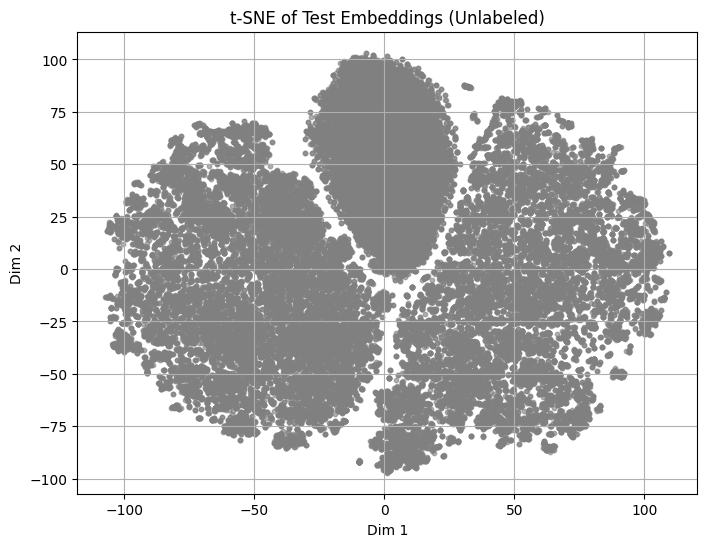

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
emb_np = embeddings_test.reshape(-1, embeddings_test.shape[-1]).cpu().numpy()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(emb_np)

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=10, alpha=0.6, c='gray')
plt.title("t-SNE of Test Embeddings (Unlabeled)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [47]:
import pandas as pd
import torch

# --- choose ONE of the two lines below ---
emb_flat = embeddings_test[:, 0, :]          # CLS‑token      (N, 512)
# emb_flat = embeddings_test.mean(dim=1)     # mean‑pooled    (N, 512)

# Convert to DataFrame and add IDs
df_embed = pd.DataFrame(emb_flat.numpy())
df_embed.insert(0, 'unique_id', test_ids)

# Save
df_embed.to_csv("test_embeddings_again.csv", index=False)
print("✅  Saved test_embeddings.csv with shape:", df_embed.shape)


✅  Saved test_embeddings.csv with shape: (10523, 513)
